In [1]:
def generate_xyz_trajectory(
    x0, y0, z0,
    vx0, vy0, vz0,
    ax0, ay0, az0,
    num_points, dt
):
    '''
    Simulate constant acceleration trajectory.
    Add noise to the output to simulate measurements.
    '''
    x, y, z = [x0], [y0], [z0]

    # Generate raw points
    for n in range(1, num_points):
        t = n * dt

        x.append( x0 + vx0*t + ax0*(t**2)/2 )
        y.append( y0 + vy0*t + ay0*(t**2)/2 )
        z.append( z0 + vz0*t + az0*(t**2)/2 )

    return x, y, z

import numpy as np
def add_noise(
    a, b, c,
    stds, mean=0
    ):
    '''
    Add gausian noise with a specified mean and variance to coordinates a, b, c to simulate
    noisy measurements

    Args:
        a b c (np.ndarray): input arrays
        stds (list[float]): 3 variances for a, b, c respectifully
        mean (float): mean for all 3 noises added
    '''
    
    sz = len(a)
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[0], size=sz)
    a_n = a + gaussian_noise
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[1], size=sz)
    b_n = b + gaussian_noise
    gaussian_noise = np.random.default_rng().normal(loc=mean, scale=stds[2], size=sz)
    c_n = c + gaussian_noise

    return a_n, b_n, c_n

import matplotlib.pyplot as plt
def plot_trajectory_1d(timestamps, data, coord_name=''):
    if (len(timestamps) != len(data)):
        print('plot_trajectory_1d(): '\
              f'expected matching input lengths, got {len(timestamps)}, {len(data)} instead.')
        return None

    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.plot(timestamps, data)
    ax.set_xlabel('Время, сек')
    ax.set_ylabel(f'Координата {coord_name}, м')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def plot_trajectory_3d(x, y, z, title=''):
    ax = plt.figure().add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(x, y, z)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

def plot_filtering_results_1d(x_pred, z, timestamps):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

    ax.plot(timestamps, x_pred, color='r', label='Предсказания фильтра')
    ax.scatter(timestamps, z, color='k', alpha=0.8, marker='.', s=8, label='Измерения')
    ax.set_xlabel('Время')
    ax.set_ylabel('Координата')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.legend()
    plt.show()
    
def plot_residues_1d(y, sigmas, timestamps, scale=1):
    '''
    Plot residues to visually evaluate perfomance of a Kalman filter.
    y is expected to be calculated as z - H@x
    Args:
        y: residues.
        sigmas: variances taken from the filter's matrix P.
        timestamps: timeline.
        scale: draw +-scale*sigmas lines to see if the residue falls between them,
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

    ax.plot(timestamps, y, label='Невязка')
    ax.plot(timestamps, scale*sigmas, linestyle='--', color='k', label=f'{scale}'+r'$\sigma$')
    ax.plot(timestamps, -scale*sigmas, linestyle='--', color='k')
    ax.fill_between(timestamps, scale*sigmas, -scale*sigmas, color='y')

    ax.grid(True, which='both', axis='y', color='gray', linestyle='--', linewidth=0.7)
    ax.set_xlabel('Время')
    ax.set_ylabel('Невязка')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.legend()
    plt.show()

import numpy as np
def xyz_to_sphere(X: list, Y:list , Z:list) -> tuple[list, list, list]:
    '''
    Convert x y z coordinates to spherical r u v

    NOTE: 
    - r is defined as sqrt(x^2 + y^2 + z^2)
    - u is defined as sin(phi_u) where phi_u is the polar angle
    - v is defined as sin(phi_v) where phi_v is the azimuth angle
    '''
    R, U, V = [], [], []
    for x, y, z in zip(X, Y, Z):
        r = np.sqrt(x**2 + y**2 + z**2)
        R.append( r )
        # u.append( np.arctan2(y, x) )
        U.append( z / r )
        # v.append( np.arctan2(z, np.sqrt(x**2 + y**2)) )
        V.append( y / np.sqrt( x**2 + y**2) )

    return R, U, V

def sphere_to_xyz(R, U, V):
    x, y, z = [], [], []
    for r, u, v in zip(R, U, V):
        x.append( r*np.cos(v)*np.cos(u) )
        y.append( r*np.cos(v)*np.sin(u) )
        z.append( r*np.sin(v) )
 
    return x, y, z

# Обычный фильтр Калмана

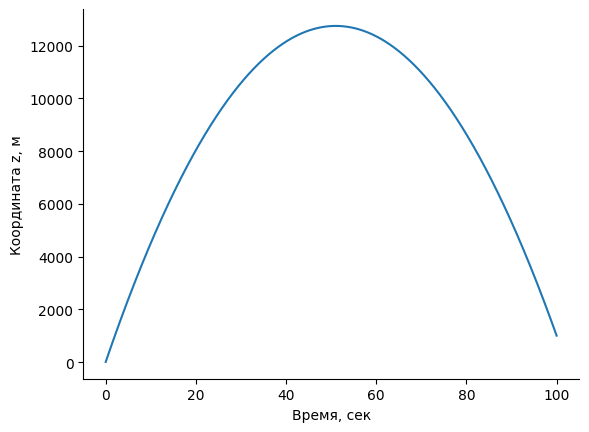

In [2]:
import numpy as np
x, y, z = generate_xyz_trajectory(
    10, 10, 10,
    500, 500, 500,
    0, 0, -9.81,
    1000, 0.1)

t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, z, coord_name='z')

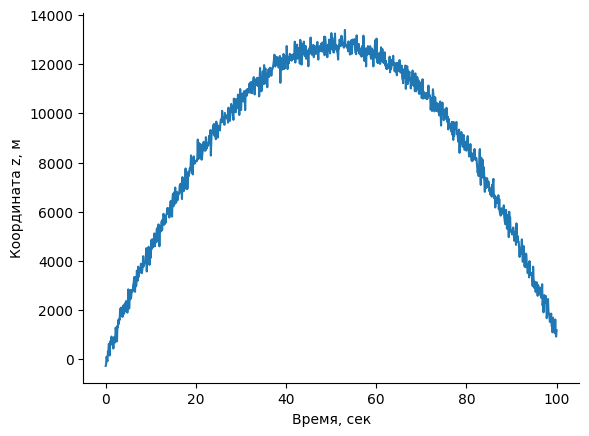

In [3]:
x_n, y_n, z_n = add_noise(x, y, z, stds=[250, 250, 250])
t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, z_n, coord_name='z')

In [4]:
from FilterLib.Kalman import Kalman

dt = 0.1

x0=np.array([10., 500.])

P = np.array([
    [250., 0],
    [0, 100.]
])
H = np.array([
    [1., 0],
])
F = np.array([
    [1., dt],
    [0, 1.]
])
B = np.array([[0]])
Q = np.array([[0.588, 1.175],
              [1.175, 2.35 ]])
R = np.array([
[25,]
])

kf = Kalman(
    dim_x=2,
    dim_m=1,
    P=P,
    F=F,
    Q=Q,
    H=H,
    R=R,
    x0=x0,
    dt=dt
)

z_n = z_n.reshape(-1, 1)
kf.add_measurement(data=z_n)
kf.calculate_all()

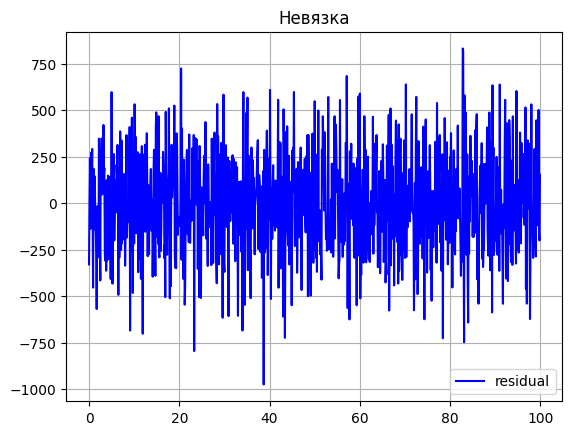

In [5]:
kf.plot_r()

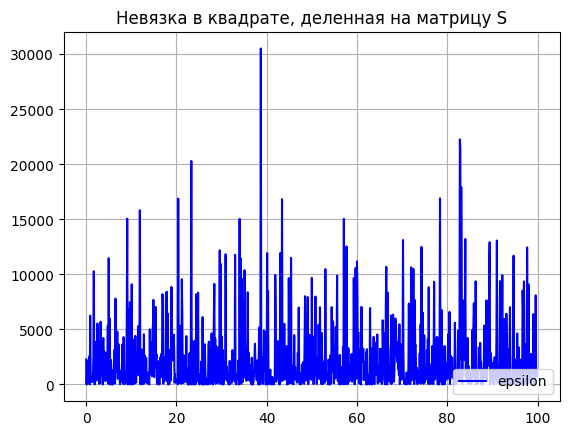

In [6]:
kf.plot_e()

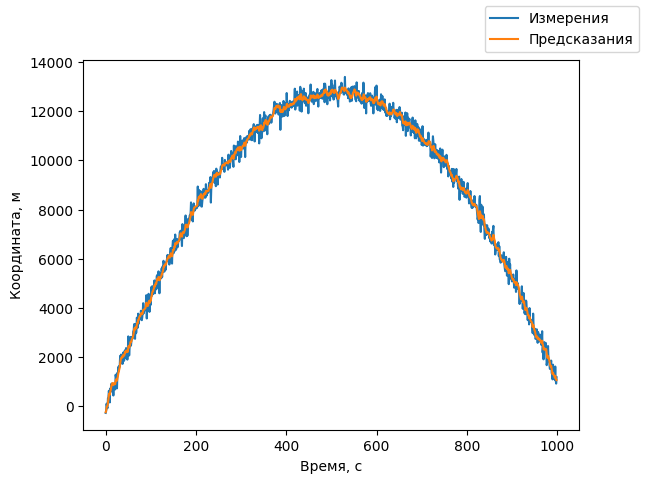

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(z_n, label='Измерения')
ax.plot(kf.posterior[:, 0], label='Предсказания')
ax.set_xlabel('Время, с')
ax.set_ylabel('Координата, м')
fig.legend()

# EKF

In [8]:
import math
from numpy.random import randn

def get_ranges(N: int, pos=0., vel=100., alt=1000., dt=0.1):
    """ 
    Симуляция измерения расстояния радаром
    N - требуемое число измерений
    """
    dists = []
    for n in range(N): 
        vel = vel  + .1*randn()
        alt = alt + .1*randn()
        pos = pos + vel*dt
    
        err = pos * 0.05*randn()
        slant_dist = math.sqrt(pos**2 + alt**2)
        
        dists.append(slant_dist + err)

    return np.asarray(dists)

r_n = get_ranges(N=1000).reshape(-1, 1)

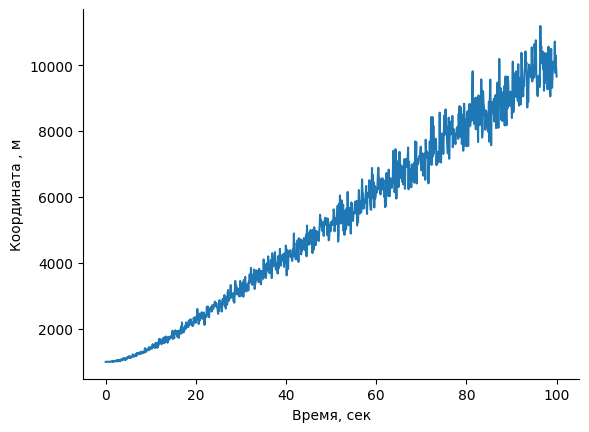

In [9]:
t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, r_n)

In [10]:
from math import sqrt
def HJacobian_at(x):
    """ Расчёт Якобиана в данной задаче для x = [x, dx/dt, y] """

    horiz_dist = x[0] # x
    altitude   = x[2] # y
    denom = sqrt(horiz_dist**2 + altitude**2)
    return np.array ([[horiz_dist/denom, 0., altitude/denom]])

In [11]:
def hx(x):
    """ Пересчёт состояния x в измерение расстояния """
    
    return (x[0]**2 + x[2]**2) ** 0.5

In [49]:
from FilterLib.EKF import EKF
import scipy

dt = 0.1
x0 = np.array([1700, 100, 1000]).T
P = np.array([
    [100., 0, 0],
    [0, 100., 0],
    [0, 0, 100]
])

# H = 

F = np.array(
    [[1., dt, 0],
    [0, 1., 0],
    [0, 0, 1]]
)

Q = scipy.linalg.block_diag(
    [[.25*dt**4, .5*dt**3],
    [ .5*dt**3,    dt**2]],
    [0.1]
    )

R = np.array([25])

kf = EKF(
    dim_x=3,
    dim_m=1,
    HJacobian=HJacobian_at,
    h=hx,
    P=P,
    F=F,
    R=R,
    x0=x0,
    dt=dt
)

In [50]:
kf.add_measurement(data=r_n)
kf.calculate_all()

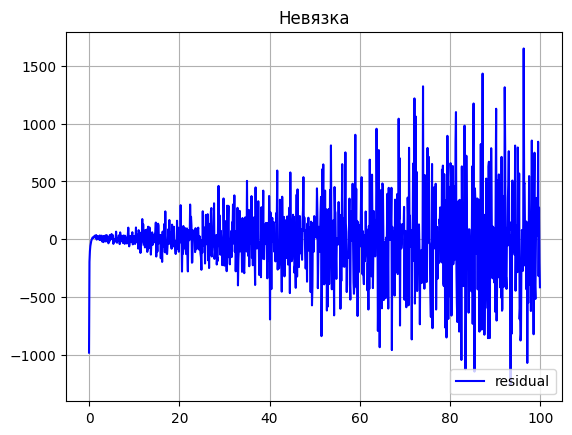

In [51]:
kf.plot_r()

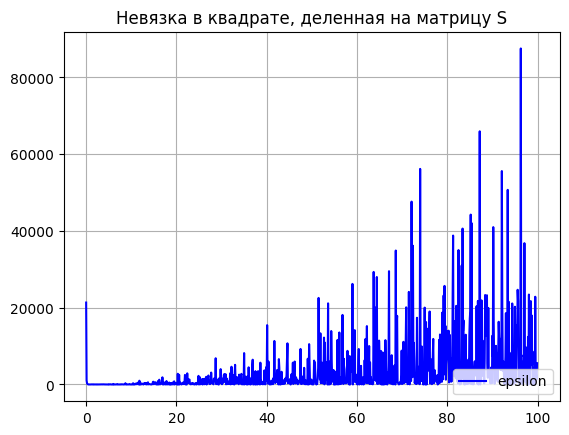

In [52]:
kf.plot_e()

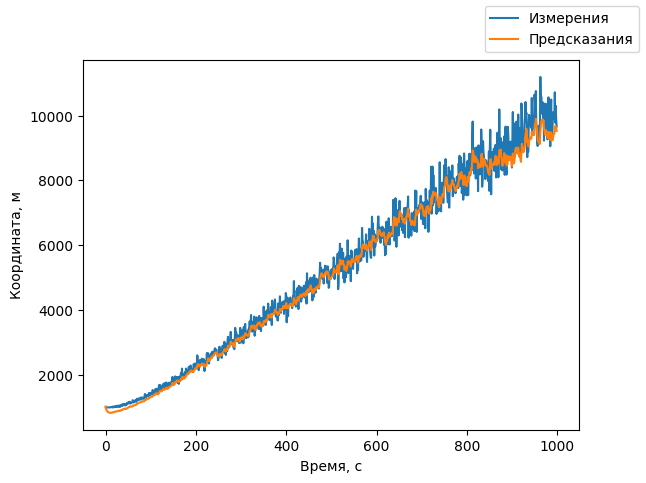

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(r_n, label='Измерения')
ax.plot(kf.posterior[:, 0], label='Предсказания')
ax.set_xlabel('Время, с')
ax.set_ylabel('Координата, м')
fig.legend()

# UKF

In [17]:
zs = np.array([[i + randn()*5, 
                i + randn()*5] for i in range(1000)])   
zs = zs
zs

array([[   2.12355218,   -2.81957181],
       [  -7.93459281,   -3.78445862],
       [   4.29759562,    4.51450232],
       ...,
       [ 988.02168308,  991.20373882],
       [ 990.23503513,  994.24846148],
       [ 990.20640128, 1002.76664731]], shape=(1000, 2))

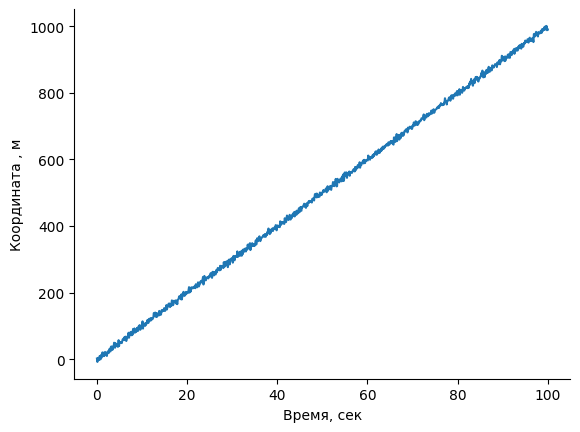

In [18]:
t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, zs[:,0])

In [19]:
t = np.linspace(0, 1000*0.1, 1000)
plot_trajectory_1d(t, zs[0, :])

plot_trajectory_1d(): expected matching input lengths, got 1000, 2 instead.


In [20]:
def f_cv(x, dt):
    """ Эволюция сигма-точки для постоянной скорости, здесб простой случай """
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x, right=False):
    """ Перевод сигма-точки в пространство измерений """
    return x[[0, 2]]

In [21]:
from FilterLib.UKF import UKF

dt = 0.1
x0 = np.array([0, 0, 0, 0]).T
P = np.array([
    [100., 0, 0, 0],
    [0, 100., 0, 0],
    [0, 0, 100, 0],
    [0, 0, 0, 100]
])

F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

Q = scipy.linalg.block_diag(
    [[.25*dt**4, .5*dt**3],
    [ .5*dt**3,    dt**2]],
    

    [[.25*dt**4, .5*dt**3],
    [ .5*dt**3,    dt**2]],
)

R = np.diag([5**2, 5.**2])

kf = UKF(
    dim_x=4,
    dim_m=2,
    P=P,
    f=f_cv,
    h=h_cv,
    Q=Q,
    R=R,
    x0=x0,
    dt=dt
)

In [22]:
kf.add_measurement(data=zs)
kf.calculate_all()

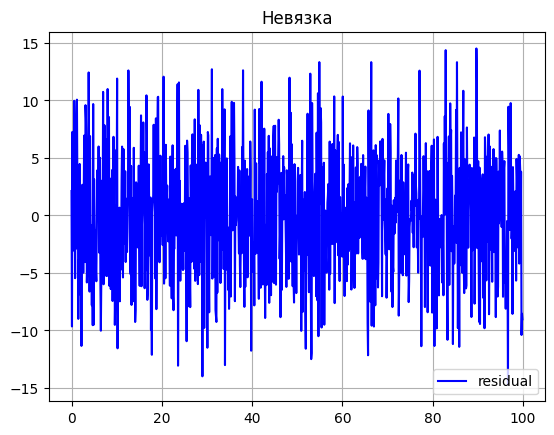

In [23]:
kf.plot_r()

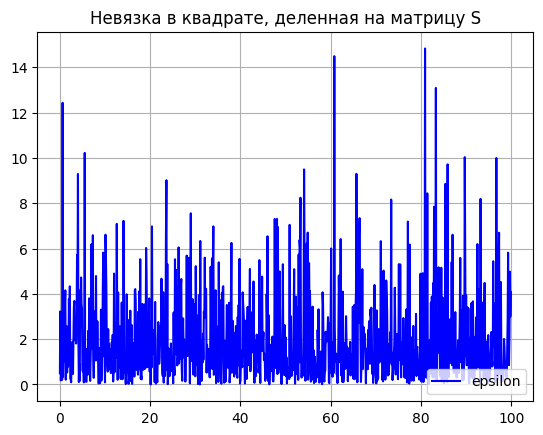

In [24]:
kf.plot_e()

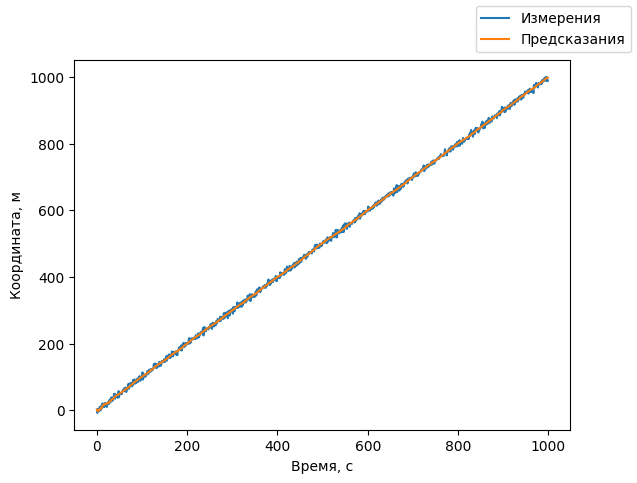

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(zs[:, 0], label='Измерения')
ax.plot(kf.posterior[:, 0], label='Предсказания')
ax.set_xlabel('Время, с')
ax.set_ylabel('Координата, м')
fig.legend()